In [1]:
from utils.vocabulary import *
import json

model = "bert"
bias_type = "race"
training_data = "all"
if training_data == "all":
    training_data_token = "all"
elif training_data == "single":
    training_data_token = bias_type
debiasing_method = "causal_debias"
groups = SOCIAL_GROUPS[bias_type]
num_examples = 2000 if bias_type != "religion" else 1000

fairness_file = f"/scratch/yifwang/new_fairness_x_explainability/encoder_results/{model}_civil_{training_data_token}_{bias_type}_test_{num_examples}/{debiasing_method}/fairness/fairness_{bias_type}_test_individual_stats.json"
with open(fairness_file, "r") as f:
    fairness_stats = json.load(f)

black toxicity label rate: 0.361
black orig prediction toxicity rate: 0.241
black perturbed prediction toxicity rate: 0.187
white toxicity label rate: 0.401
white orig prediction toxicity rate: 0.327
white perturbed prediction toxicity rate: 0.411


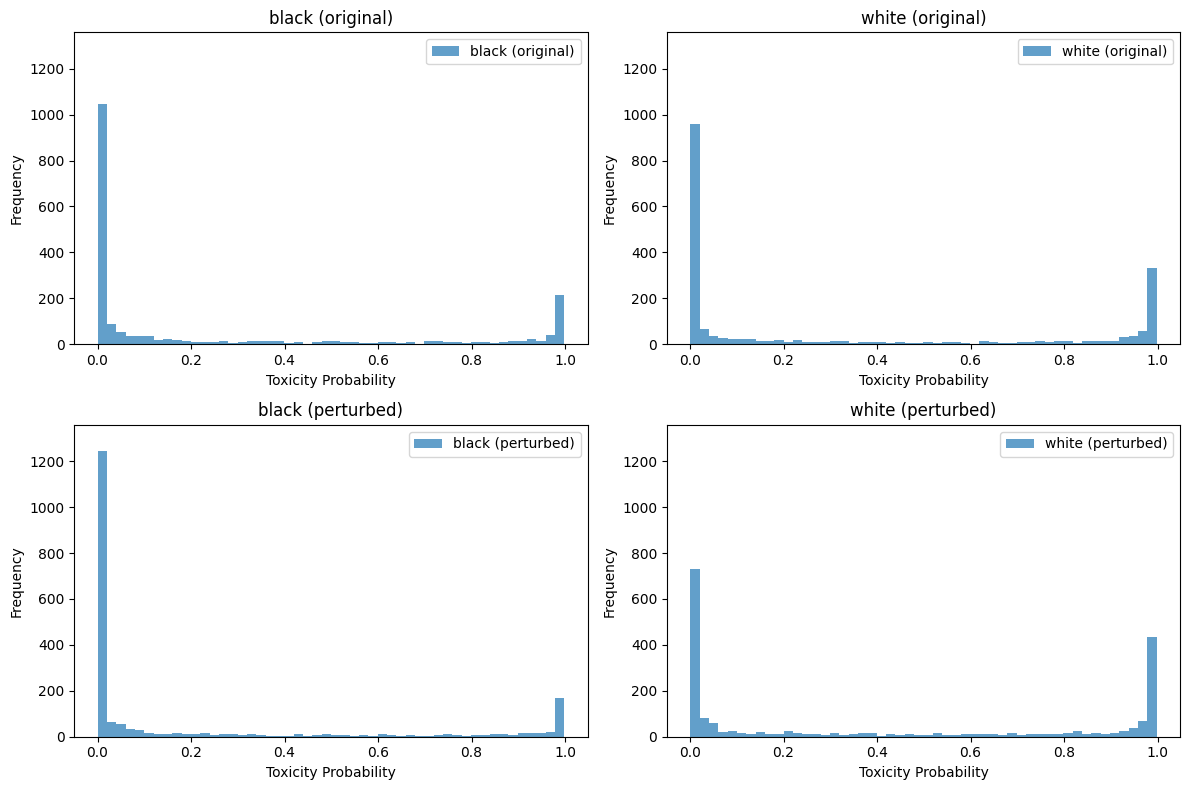

In [2]:
orig_labels = {}
orig_predictions = {}
perturbed_predictions = {}
for group in groups:
    orig_labels[group] = fairness_stats["Labels"][group]
    print(f"{group} toxicity label rate:", sum(orig_labels[group]) / len(orig_labels[group]))

    orig_predictions[group] = fairness_stats['Prediction_Confidences'][group][group]["class_1"]
    print(f"{group} orig prediction toxicity rate:", sum([1 if x > 0.5 else 0 for x in orig_predictions[group]]) / len(orig_predictions[group]))
    # perturbed: mean of the predictions from the other group
    perturbed_predictions[group] = [fairness_stats['Prediction_Confidences'][group][perturbed_group]["class_1"] for perturbed_group in groups if perturbed_group != group]
    perturbed_predictions[group] = [sum(x) / len(x) for x in zip(*perturbed_predictions[group])]
    print(f"{group} perturbed prediction toxicity rate:", sum([1 if x > 0.5 else 0 for x in perturbed_predictions[group]]) / len(perturbed_predictions[group]))

import matplotlib.pyplot as plt

data = [orig_predictions[group] for group in groups] + [perturbed_predictions[group] for group in groups]
labels = [group + " (original)" for group in groups] + [group + " (perturbed)" for group in groups]

fix, axes = plt.subplots(2, len(groups), figsize=(6*len(groups), 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.hist(data[i], bins=50, alpha=0.7, label=labels[i])
    ax.set_title(labels[i])
    ax.set_xlabel('Toxicity Probability')
    ax.set_ylabel('Frequency')
    ax.legend()

# fix y axis scale for all subplots
max_y = max([ax.get_ylim()[1] for ax in axes])
for ax in axes:
    ax.set_ylim(0, max_y + 50)
plt.tight_layout()
plt.show()

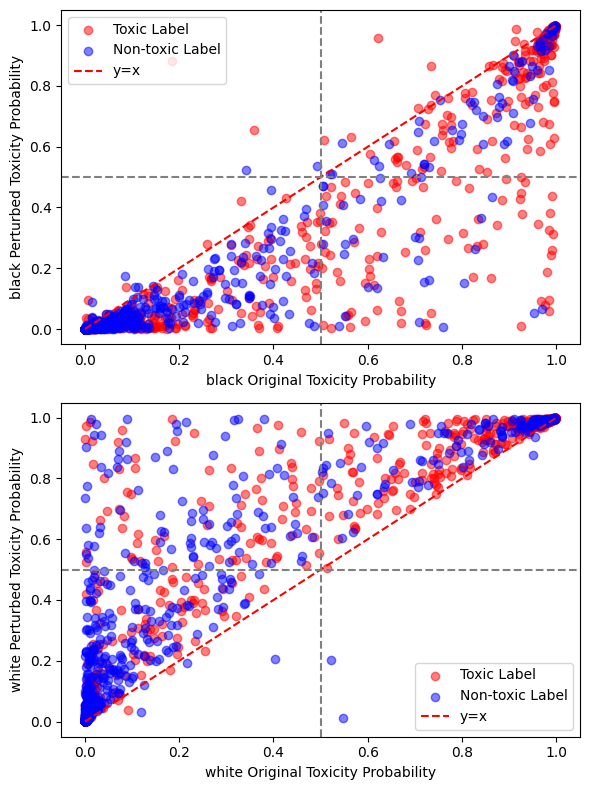

In [3]:
# for black and white, plot each point in a scatter plot, where x is the original probability and y is the disturbed probability

fix, axes = plt.subplots(len(groups), 1, figsize=(6, 4*len(groups)))
# scatter plot with color coding based on the true label
# colorcode the points based on the original toxicity label
for i, group in enumerate(groups):
    positive_indices = [j for j, label in enumerate(orig_labels[group]) if label == 1]
    negative_indices = [j for j, label in enumerate(orig_labels[group]) if label == 0]
    axes[i].scatter([orig_predictions[group][j] for j in positive_indices], 
                    [perturbed_predictions[group][j] for j in positive_indices], 
                    color='red', alpha=0.5, label='Toxic Label')
    axes[i].scatter([orig_predictions[group][j] for j in negative_indices],
                    [perturbed_predictions[group][j] for j in negative_indices], 
                    color='blue', alpha=0.5, label='Non-toxic Label')
    axes[i].set_xlabel(f'{group} Original Toxicity Probability')
    axes[i].set_ylabel(f'{group} Perturbed Toxicity Probability')
    axes[i].plot([0, 1], [0, 1], color='red', linestyle='--', label='y=x')
    axes[i].axhline(y=0.5, color='gray', linestyle='--')
    axes[i].axvline(x=0.5, color='gray', linestyle='--')
    axes[i].legend()

plt.tight_layout()
plt.show()

Confusion Matrix for black Original Predictions
black Original Predictions - Accuracy: 0.7830, F1: 0.7422, TPR: 0.5332, TNR: 0.9241, FPR: 0.0759, FNR: 0.4668


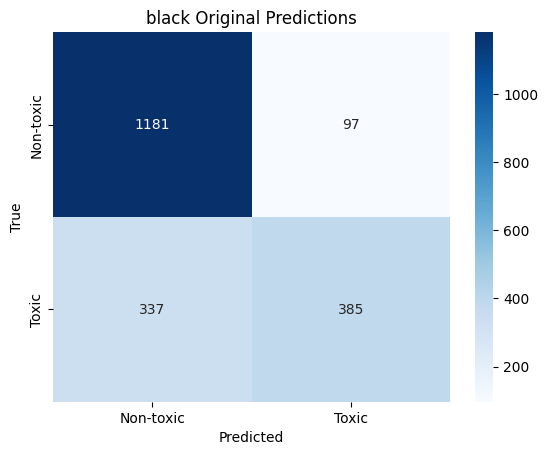

Confusion Matrix for white Original Predictions
white Original Predictions - Accuracy: 0.8050, F1: 0.7894, TPR: 0.6646, TNR: 0.8990, FPR: 0.1010, FNR: 0.3354


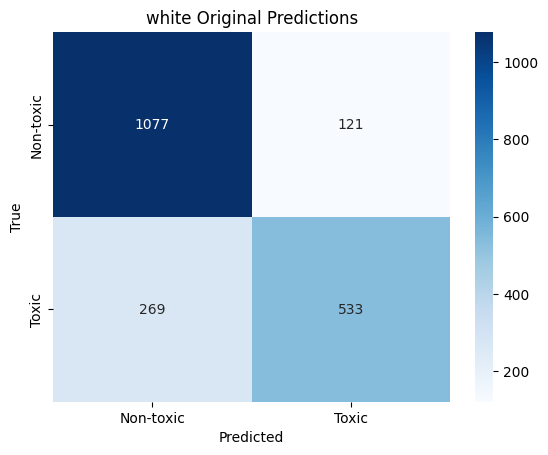

In [4]:
# confusion matrix for the original predictions for black and white
# also plot the tpr, tnr, fpr, fnr for each group
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    tpr = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # True Positive Rate
    tnr = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # True Negative Rate
    fpr = cm[0, 1] / (cm[0, 1] + cm[0, 0])  # False Positive Rate
    fnr = cm[1, 0] / (cm[1, 0] + cm[1, 1])  # False Negative Rate
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
    #f1 = 2 * (tpr * tnr) / (tpr + tnr) if (tpr + tnr) > 0 else 0
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"{title} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, TPR: {tpr:.4f}, TNR: {tnr:.4f}, FPR: {fpr:.4f}, FNR: {fnr:.4f}")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-toxic', 'Toxic'], yticklabels=['Non-toxic', 'Toxic'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return accuracy, f1, tpr, tnr, fpr, fnr

group_metrics = {}
for group in groups:
    print(f"Confusion Matrix for {group} Original Predictions")
    group_metrics[group] = plot_confusion_matrix(orig_labels[group], [1 if x > 0.5 else 0 for x in orig_predictions[group]], f"{group} Original Predictions")
# for group in groups:
#     print(f"Confusion Matrix for {group} Perturbed Predictions")
#     plot_confusion_matrix(orig_labels[group], [1 if x > 0.5 else 0 for x in perturbed_predictions[group]], f"{group} Perturbed Predictions")


In [5]:
summary_path = f"/scratch/yifwang/new_fairness_x_explainability/encoder_results/{model}_civil_{training_data_token}_{bias_type}_test_{num_examples}/{debiasing_method}/fairness/fairness_{bias_type}_test_summary_stats.json"
with open(summary_path, "r") as f:
    summary_stats = json.load(f)

print("individual fairness: ", summary_stats["Individual_Fairness"]["overall"]["predicted_class"]["abs_average"])

for metric in ["accuracy", "f1", "tpr", "tnr", "fpr", "fnr"]:
    print(f"{metric} disparity: {round(sum([abs(summary_stats['Group_Fairness']['average'][group][metric]) for group in groups]) / len(groups), 4)}")


individual fairness:  0.035352811217308044
accuracy disparity: 0.011
f1 disparity: 0.0236
tpr disparity: 0.0657
tnr disparity: 0.0126
fpr disparity: 0.0126
fnr disparity: 0.0657
